# Analyzing attitudes towards Nuclear Power using Tweets:
### A statistical inquiry into the public discourse on Twitter regarding Nuclear Energy


#### By: Tuomas Rickansrud, Elizabeth Stampher, Lulu Xue, Emilio Barbosa-Valdiosera

#### STA 141B F22 with Dr. Peter Kramlinger

## Abstract and Introduction:

Nuclear power is a potential solution to the problem of carbon-emitting energy generation, but it has historically been a controversial topic among members of the public. Our group seeks to investigate the current state of public discourse surrounding nuclear energy by running a sentiment analysis on statements made by users on Twitter.

The current state of the Global Energy Industry is rife with problems and controversy. Main oil and gas suppliers are increasing prices in a cartel-like manner, and the effects are being felt all over the developed world. Coupled with this, the effects of decades of drilling for oil and its carbon emissions are wreaking havoc on our planet. With many developed countries, such as the United States, United Kingdom, and Germany struggling to meet the energy needs of their populations, and many developing countries such in the Middle East and Africa beginning to especially suffer from the effects of carbon emissions, discussions regarding alternative sources of energy have ramped up. It is in this current polemic climate that our group decided to conduct a statistical analysis regarding how the general public currently feels about nuclear energy as an alternative. In order to conduct this type of statistical analysis, we needed to obtain data from a public source that includes as wide of a range of opinions as possible. To fulfill this need, we decided that Twitter, despite its faults, would be the best, as its short-form method of broadcasting opinions and ease of access for the general public provides us the foundation we need to conduct our analysis.

## Data Gathering:

For the data gathering methods, we sourced the data using a Twitter Backdoor through the use of a package called ‘Twint’. Twint allows us to scrape tweets from twitter and customize the search terms to more accurately satisfy our needs. The Twint script we wrote and ran searched for 5000 tweets with the search term “Nuclear Energy”, and then compiled a .json file of these tweets. In order to conduct this step, we made use of the “twint” and “json” packages.

### tweet_df Acquisition:

In [164]:
import pandas as pd
import nltk
import requests
import twint
import nest_asyncio
import json
import re
from textblob import TextBlob
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nest_asyncio.apply()
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\L S\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Twint is used to pull tweets from Twitter:

In [165]:
# c = twint.Config()
# c.Search = 'Nuclear Energy'
# c.Limit = 5000
# c.Store_json = True
# c.Output = 'twit_data.json'
# twint.run.Search(c)

In [166]:
# c = twint.Config()
# c.Search = 'Nuclear Power'
# c.Limit = 5000
# c.Store_json = True
# c.Output = 'twit_data.json'
# twint.run.Search(c)

## Data Cleaning:

Sourcing data from a social media platform inherently comes with a slew of problems. For starters, a noticeable amount of unrelated tweets containing the search term “Nuclear Energy” were collected, many of them being insults between twitter users in arguments. In addition to “Nuclear Energy” being used outside of a context regarding itself, a lot of tweets about the Russo-Ukrainian conflict were unintentionally added, as the various Nuclear Power Plants located within Ukrainian borders have been a point of contention between the two countries. After overcoming these two hurdles, we continued cleaning the tweets using methods commonly found in text and sentiment analysis preparation, such as the removal of stop words, punctuation, emojis, non-English tweets, along with lemmatizing the leftover words of interest. Coupled with these basic methods of cleaning text, we used One-hot encoding to vectorize the cleaned tweets for input into the various algorithms we used in this project. We decided to use these methods because it afforded us a good degree of flexibility while we were still deciding on which algorithm and/or model to use. 

### dataremoved Cleaning:

In [167]:
f = open(r'twit_data.json', 'rb')
data = [json.loads(line) for line in f]
tweet_df = pd.DataFrame(data)
tweet_df = tweet_df[['tweet','link']]
tweet_df = tweet_df.drop_duplicates()
dataremoved = tweet_df[~tweet_df.iloc[:,0].str.contains('Ukraine')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukraine')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Ukrainian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukrainian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Ukrainians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukrainians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Zaporizhzhia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('war')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russians')]

In [168]:
#%% RANDOMLY PULLING TRAINING TWEETS

traindf = dataremoved.sample(frac=0.1, random_state=0)

#%% REMAINDER DATA FRAME

remainderdf = dataremoved.loc[~dataremoved.index.isin(traindf.index)]

# INITIAL PORTIONS
trainingset_1 = traindf[:222]
trainingset_2 = traindf[222:444]
trainingset_3 = traindf[444:666]
trainingset_4 = traindf[666:]

# EXPORTED TO CSV


# THEN WE PULLED MORE
trainingset_5_6 = remainderdf.sample(444, random_state=0)
#updating remainder set
remainderdf = remainderdf.loc[~remainderdf.index.isin(trainingset_5_6.index)]

# pulled another
trainingset_7_8 = remainderdf.sample(444, random_state=0)
# updating remainder set
remainderdf = remainderdf.loc[~remainderdf.index.isin(trainingset_7_8.index)]

Then we exported the sets and labelled the training sets.

In [169]:
# trainingset_1.to_csv('trainingset_1.csv',encoding='utf-8-sig', header=None)
# trainingset_2.to_csv('trainingset_2.csv',encoding='utf-8-sig', header=None)
# trainingset_3.to_csv('trainingset_3.csv',encoding='utf-8-sig', header=None)
# trainingset_4.to_csv('trainingset_4.csv',encoding='utf-8-sig', header=None)
# trainingset_5_6.to_csv('trainingset_5_6.csv',encoding='utf-8-sig', header=None)
# trainingset_7_8.to_csv('trainingset_7_8.csv',encoding='utf-8-sig', header=None)

# remainderdf.to_csv('remainder.csv',encoding='utf-8-sig', header=None)

After some manual labelling and dropping non-English tweets in excel, we end up with two sets of files: The manually labelled set to be used as a training set for k-NN, and the unlabelled remainder set to be used as a test set for k-NN. We have 1,175 tweets which are manually labelled by the four of us, and 5,450 tweets remained unlabelled for our models to predict. We use the combined set of all tweets to be used in LDA to distinguish topic distributions that apply to the full data.

Below, we have plotted our distribution of manually sentiment labelled tweets:

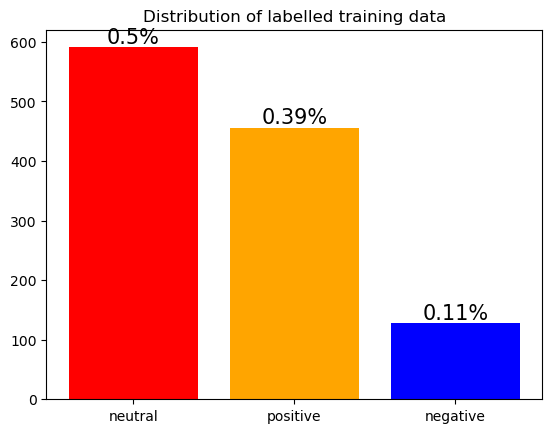

In [214]:
# read the labelled training data
labelled = pd.read_csv('labelled.csv',header=None)
# make bar plot
freq = np.array(np.unique(labelled.iloc[:,2], return_counts=True)).T
freq_data = sorted(
                    [(name, float(val)) for name, val in freq],
                     key=lambda x:x[1],
                     reverse=True
                    )

colors_list = ['Red', 'Orange', 'Blue']
p1 = plt.bar(*zip(*freq_data), color=colors_list)

n = len(labelled.iloc[:,2])
for rect1 in p1:
    height = rect1.get_height()
    plt.annotate("{}%".format(round(height/n, 2)), (rect1.get_x() + rect1.get_width()/2,
                                        height+.05), ha="center", va="bottom", fontsize=15)

# add title for plots
plt.title('Distribution of labelled training data')
plt.show()

Now that the sets have been manually looked at and labelled, they are imported into the code as .csv files for further cleaning necessary for the algorithms. (all.csv, labelled.csv, and the remainder.csv) Starting with LDA:

In [170]:
labelled = pd.read_csv('labelled.csv',header=None)
labelled = labelled.iloc[:,1:3]
labelled.columns = ['tweets','label']

remainder = pd.read_csv('remainder.csv',header=None)
remainder = remainder.iloc[:,1:]
remainder.columns = ['tweets']

#%%

data = pd.concat([labelled['tweets'],remainder['tweets']])
#%%
#data = data.iloc[:,1]
#data.columns = ['tweets']

In [171]:
cleaned_tweets = []
words = []
for tweet in data:
    clean = re.sub(r"(http[s]?\://\S+)|([\[\(].*[\)\]])|([#@]\S+)|\n", "", str(tweet))
    clean = re.sub(r"\d", '', clean)
    clean = re.sub(r"'\S+", '', clean)
    clean = clean.replace('.', '').replace(';', '').lower()
    words += re.findall(r"(?:\w+|'|’)+", clean)
    cleaned_tweets.append(clean)

stopwords = nltk.corpus.stopwords.words("english")
standardized = [w for w in words if w not in stopwords]

# removing other symbols
corpus = [[re.sub('[^a-zA-Z ]', ' ', document)] for document in cleaned_tweets]
#tokenizing
corpus_tokenized = [nltk.word_tokenize(document[0]) for document in corpus]
# stop words
stopwords = nltk.corpus.stopwords.words("english")
corpus_tokenized = [[word for word in document if word not in stopwords] for document in corpus_tokenized]
# lemmatizing
nltk.download('wordnet')
corpus_lemmatized = [[nltk.WordNetLemmatizer().lemmatize(word) for word in document] for document in corpus_tokenized]
# stitching back together
corpus = [' '.join(document) for document in corpus_lemmatized]
# string obj for VADER
corpus_string = ""
for tweet in corpus:
    corpus_string += tweet

[nltk_data] Downloading package wordnet to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Imported tweets are run through the cleaning code above, and then stitched back together in this next cell for use in the k-NN algorithm:

In [172]:
# CLEANED k-NN INPUT FOR PER WORD
labelled_cleaned = pd.DataFrame(corpus[:1175])
labelled_cleaned = labelled_cleaned.join(labelled['label'])
labelled_cleaned.columns = ['tweets','label'] 

remainder_cleaned = pd.DataFrame(corpus[1175:])
remainder_cleaned.columns = ['tweets']

#### First Model: Preliminary LDA

For the first model we will be using to run the sentiment analysis, we chose to use the Latent Dirichlet Algorithm, otherwise known as LDA (Not to be confused with Linear Discriminant Analysis). LDA is intended to identify a set number of topics in text. We started by choosing two topics to base our LDA on, in order to see if we are able to identify whether any of the two topics appeared to show positive or negative sentiment towards the topic of Nuclear Energy. Once we were able to generate two topics from the use of this algorithm on our processed tweets, we were able to visualize the outcomes through the use of word clouds as well as an interactive topic visualization.

We will be using the gensim package's LDA model because it seems to have more LDA-specific features such as coherence score calculation, which will help us better see how the model is performing.

In [210]:
import numpy as np
import re
import string
#import spacy
import gensim
from gensim import corpora
#import pyLDAvis
#import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
dictionary = corpora.Dictionary(corpus_lemmatized)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in corpus_lemmatized]

In [212]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=2, random_state=100,
                chunksize=1000, passes=50,iterations=100)

The two topics are output here:

In [176]:
# topic display
posterior = lda_model.print_topics()
two_topic_LDA = pd.DataFrame(posterior)[1]
two_topic_LDA = two_topic_LDA.transpose()
two_topic_LDA.index = ['topic ' + str(i) for i in range(0,2)]
two_topic_LDA.name = 'words'

two_topic_LDA

topic 0    0.068*"nuclear" + 0.054*"power" + 0.028*"energ...
topic 1    0.038*"nuclear" + 0.032*"energy" + 0.010*"amp"...
Name: words, dtype: object

And we visualize the topics as word clouds with each word's respective assigned weight:

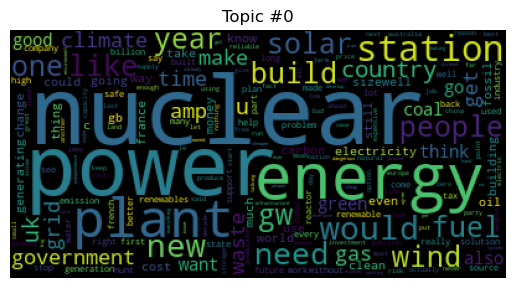

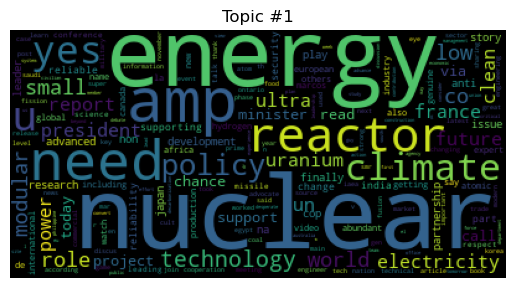

In [177]:
# word clouds
from wordcloud import WordCloud

for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

As seen here, there does not exist a clear difference in sentiment between the two topics. For example, Topic 0 contains the word “good”, and Topic 1 contains the good “yes”. Both word clouds also included negative words, such as “problem” in topic 0 and “issue” in topic 1. Given the inconsistency stemming from seeing both positive and negative words in both topics, we can conclude that LDA alone cannot identify a clear sentiment towards Nuclear Energy in either group.

What we decide to do, then, is try to optimize our LDA model for use in another algorithm with a more distinct classification method, and see if this yields better results. The classification algorithm we chose is k-Nearest Neighbors. In order to use LDA with k-NN, we need to test our LDA model for the optimal number of topics to be used as vector dimensions. For LDA, there is no single objective method known to be best, but seeking out the maximum coherence scores seems to perform better than other metrics. We calculate u_mass coherence scores, which run on a scale from -14 to +14, and we plot the scores across a range of LDA topic numbers below:

In [179]:
#%% GRAPH FUNCTION

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [180]:
# build list of scores across different topic numbers

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=corpus_lemmatized, start=2, limit=50, step=1)

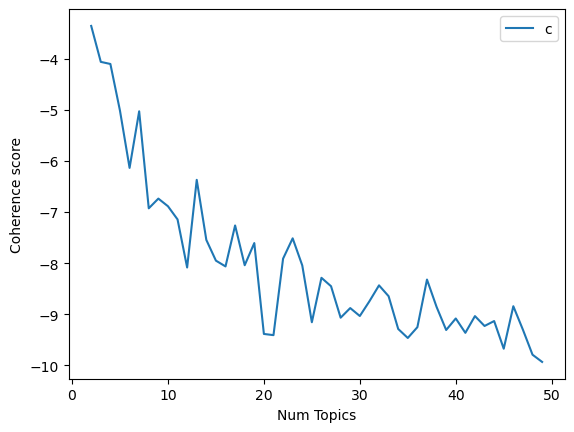

In [181]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Based on this graph, 2 topics appears to generate the highest coherence score for our LDA model, so we decide to stick with a 2 dimensional input into our classification algorithm with the topics as dimensions.

These topic distributions can also be visualized in the interactive element below. Good topic distributions will generate fairly large circles which do not overlap and are placed randomly in the plane. There are only two topics identified here, so placement in the plane can not take on any particular shape, but they do not appear to overlap. The word distributions and their assigned weights in the LDA model can be seen on the right when each topic circle is clicked:

In [183]:
import pyLDAvis
import pyLDAvis.gensim_models
vis_data = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.show(vis_data, open_browser=False, local=False)

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]

stopping Server...


For use in k-NN, we need to generate the 2-dimensional vectors for each tweet in the set. These vectors represent the topic probabilities LDA has assigned for each tweet. We do this below:

In [185]:
#%% MATRIX TIME, THIS OUTPUT WILL GO INTO K-NN

tweet_vectors = pd.Series(0)
for i in range(len(doc_term_matrix)):    
    tweet_vectors[i] = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0, minimum_phi_value=None, per_word_topics=False)

tweet_vectors_entries = [[tweet_vectors[i][0][1],tweet_vectors[i][1][1]] for i in range(len(tweet_vectors))]

LDA_tweet_frame = pd.DataFrame(tweet_vectors_entries, columns = ['Topic 0','Topic 1'])

In [186]:
#%% MATRIX TIME, THIS OUTPUT WILL GO INTO K-NN

tweet_vectors = pd.Series(0)
for i in range(len(doc_term_matrix)):    
    tweet_vectors[i] = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0, minimum_phi_value=None, per_word_topics=False)

#%%

tweet_vectors_entries = [[tweet_vectors[i][0][1],tweet_vectors[i][1][1]] for i in range(len(tweet_vectors))]

LDA_tweet_frame = pd.DataFrame(tweet_vectors_entries, columns = ['Topic 0','Topic 1'])

In [187]:
# Separating the sets again (training and labelled) to go into k-NN

labelled_lda = LDA_tweet_frame.iloc[:1175,:]
remainder_lda = LDA_tweet_frame.iloc[1175:,:]

#%%
labelled_lda = labelled_lda.join(labelled['label'])
#%%
labelled_lda.columns = ['Topic 0','Topic 1','label']

### Second Model: K-NN

The second model we will use to classify sentiment in our tweets is k-NN.

Since our two-topic LDA model does not seem suitable for sentiment classification on its own, we will use tweets vectorized by the LDA model as inputs for k-NN classification. We will then compare this to two k-NN models which use one-hot encoded sets of tweets, one which has been cleaned of usernames, symbols, non-English characters, stop words, and lemmatized, and another which leaves the tweets completely untouched.

In [188]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
import nltk
from sklearn.model_selection import train_test_split

In [189]:
# FOR LDA VECTORS:
train_data_lda = labelled_lda
test_data_lda = remainder_lda

##### LDA-based k-NN:

Our first job with k-NN is to use our labelled data set to test the model for accuracy. The LDA vectorized labelled set is fed into the algorithm here:

In [190]:
# %% for labelled_LDA_vectors and remainder_LDA_vectors
X = train_data_lda.iloc[:1175, :2]
y = train_data_lda.iloc[:1175, 2]

The labelled LDA vectors are then split into a 10% training and 90% validation set:

In [191]:
# %% Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=7)

In [192]:
# check the optimal k for KNN
def find_optimal_k(X_train,y_train,X_val,y_val):
    neighbors = np.arange(1, 20)
    train_accuracy = np.empty(len(neighbors))
    val_accuracy = np.empty(len(neighbors))
    # Loop over K values
    max_acc = 0
    optimal_k = 0
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(X_train, y_train)
        val_accuracy[i] = knn.score(X_val, y_val)
        if val_accuracy[i] > max_acc and i!=1:
            max_acc = val_accuracy[i]
            optimal_k = i

    # Generate plot
    plt.plot(neighbors, val_accuracy, label='Validation dataset Accuracy')
    plt.plot(neighbors, train_accuracy, label='Training dataset Accuracy')

    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('Accuracy')
    plt.show()

    print("The optimal k is: ", optimal_k)
    return optimal_k

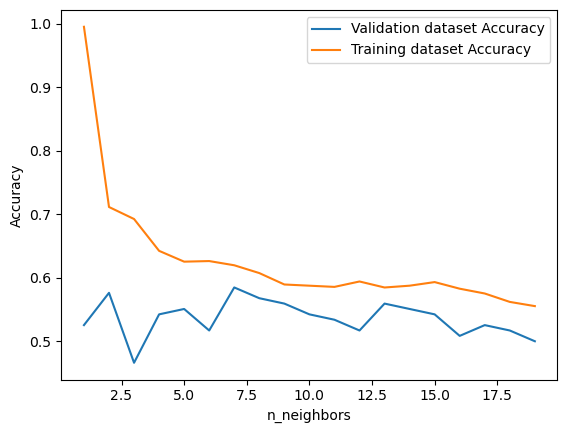

The optimal k is:  6


In [193]:
k = find_optimal_k(X_train,y_train,X_val,y_val)

After the k-NN algorithm is trained on the small subset of labelled tweets (plotted in orange), it classifies the validation set (plotted in blue), and the accuracy for both is output. The optimal number of neighbors is then identified for the labelled set, at k = 6. The confusion matrix for this trial is then output:

In [194]:
# %% Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score


def making_confusion_mat(X_train,y_train,X_val,y_val,optimal_k):
    # input: X_train,y_train,X_val,y_val and optimal_k
    classifier = KNeighborsClassifier(n_neighbors=optimal_k, metric='minkowski', p=2)
    classifier.fit(X_train, y_train)
    y_pred_val = classifier.predict(X_val)
    cm = confusion_matrix(y_val, y_pred_val)
    ac = accuracy_score(y_val, y_pred_val)
    
    # retun the confusion matrix, accuracy, and knn model
    return cm, ac, classifier, y_pred_val

In [195]:
res_lda = making_confusion_mat(X_train,y_train,X_val,y_val,k)
# output confusion matrix
res_lda[0]

array([[ 1,  5,  6],
       [ 6, 41, 14],
       [ 6, 20, 19]], dtype=int64)

And the accuracy for the labelled set is output:

In [196]:
# output the accuracy corresponding to optimal k for validation data
print("The accuracy of validation set is: ", res_lda[1])

The accuracy of validation set is:  0.5169491525423728


##### k-NN prediction of LDA vector sentiment labels:

The next step is to try the k-NN algorithm as a sentiment label predictor on our unlabelled data, and compare its predicted label distribution to that of the pre-labelled distribution. It is input here:

In [197]:
# %% predict labels for test data
classifier = res_lda[2]
y_pred_test_lda = classifier.predict(test_data_lda.iloc[:,:])
y_pred_val_lda = res_lda[3]

In [198]:
# draw bar plots for distributions
def bar_plot(dataset, d_type):
    freq = np.array(np.unique(dataset, return_counts=True)).T
    freq_data = sorted(
                        [(name, float(val)) for name, val in freq],
                         key=lambda x:x[1],
                         reverse=True
                        )

    colors_list = ['Red', 'Orange', 'Blue']
    p1 = plt.bar(*zip(*freq_data), color=colors_list)

    n = len(dataset)
    for rect1 in p1:
        height = rect1.get_height()
        plt.annotate("{}%".format(round(height/n, 2)), (rect1.get_x() + rect1.get_width()/2,
                                            height+.05), ha="center", va="bottom", fontsize=15)
    
    # add title for plots    
    plt.title('Prediction results for '+ d_type)
    plt.show()

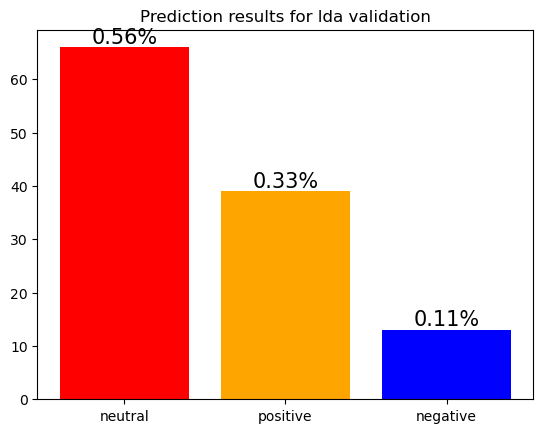

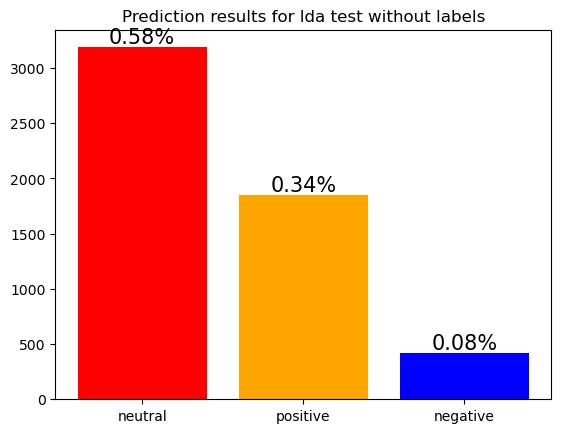

In [199]:
bar_plot(y_pred_val_lda, 'lda validation')  # bar plot for validation set for lda
bar_plot(y_pred_test_lda, 'lda test without labels')   # bar plot for test set for lda

The top bar plot represents the pre-labelled classification validation distribution, and the bottom plot represents the predicted label distribution. As you can see, the two trials have roughly similar distributions, with most tweets being classified as neutral sentiment, followed by positive sentiment, followed by negative sentiment. 

Interestingly, this model appears to produce a sentiment label distribution that fairly closely resembled the distribution of our manually assigned labels seen previously, despite this model having an accuracy score of only 51%.

##### k-NN with uncleaned tweets:

We now run the k-NN algorithm with raw word inputs, rather than LDA vectors. The first trial will be run with completely uncleaned tweets, encoded with one-hot encoding:

In [200]:
# define the one-hot encoding
def one_hot_encoding_tweets(data):
    # 1. create a CountVectorizer
    vec = CountVectorizer(tokenizer = nltk.word_tokenize)
    # convert the type of "tweets" to str
    data["tweets"] = data["tweets"].astype(str)
    tweet_list = list(data['tweets'])
    freq = vec.fit_transform(tweet_list)
    # create one-hot encoding
    ohot = Binarizer().fit_transform(freq)
    # one-hot encoding
    corpus_binary = ohot.todense()

    # convert matrix to dataframe
    encoder_df = pd.DataFrame(corpus_binary)

    # create x and y for knn
    x = encoder_df
    y = data['label']

    return x,y

In [201]:
# data_labelled: original tweets
# data_labelled_cleaned: cleaned version
data_labelled = labelled
data_labelled_cleaned = labelled_cleaned

In [202]:
# %% predict the results of test set
colnames = ['tweets']
data_test = remainder
data_test_cleaned = remainder_cleaned
data_test['label'] = ""
data_test_cleaned['label'] = ''

In [203]:
def merge_d(train_data, test_data):
    merge_data = train_data.append(test_data, ignore_index=True)

    # test the optimal k for the accuracy
    X = one_hot_encoding_tweets(merge_data)[0]
    y = one_hot_encoding_tweets(merge_data)[1]

    # Split into training and validation set and check the optimal k
    X_x = X.loc[:1174, :]
    y_y = y[:1175]

    X_train, X_val, y_train, y_val = train_test_split(
        X_x, y_y, test_size=0.1, random_state=0)
    
    # check the optimal k value
    k = find_optimal_k(X_train,y_train,X_val,y_val)
    
    # making confusion matrix
    res = making_confusion_mat(X_train,y_train,X_val,y_val, k)
    print("The confusion matrix for validation data is: \n", res[0])
    print("The accuracy of validation is: ", res[1])
    

    # predict labels of test data
    X_test = X.loc[1175:, :]
    classifier = res[2]
    y_pred_test = classifier.predict(X_test)
    y_pred_val = res[3]

    return merge_data, y_pred_test, y_pred_val

Once again, we check the model for accuracy by feeding the pre-labelled set (separated into 10% training and 90% validation) into the algorithm as well as identifing the optimal number of neighbors:

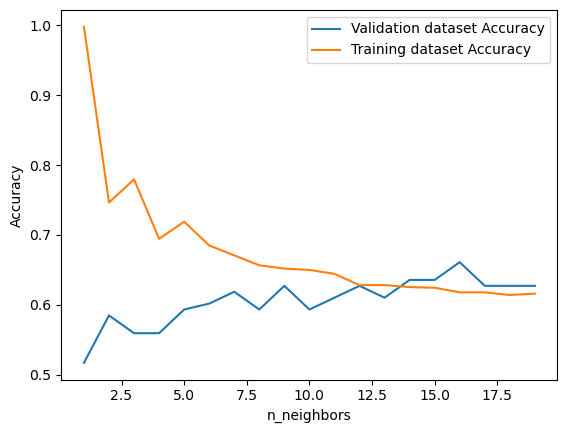

The optimal k is:  15
The confusion matrix for validation data is: 
 [[ 0  7  3]
 [ 0 58 11]
 [ 0 22 17]]
The accuracy of validation is:  0.635593220338983


In [204]:
res_uncleaned = merge_d(data_labelled, data_test)
y_pred_test_uncleaned = res_uncleaned[1]
y_pred_val_uncleaned = res_uncleaned[2]

In this case, the optimal number of neighbors is 15, and the validation model clocks in at an accuracy of roughly 64%.

##### k-NN prediction of uncleaned tweet sentiment labels:

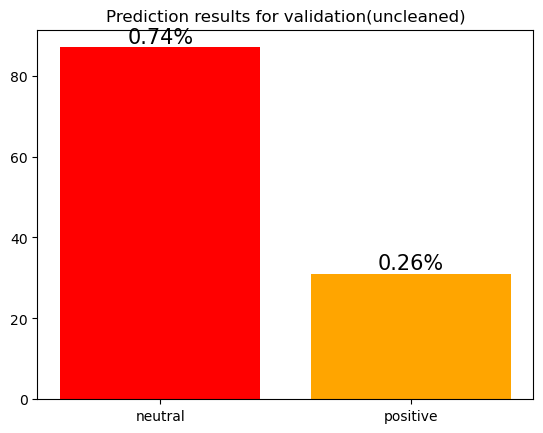

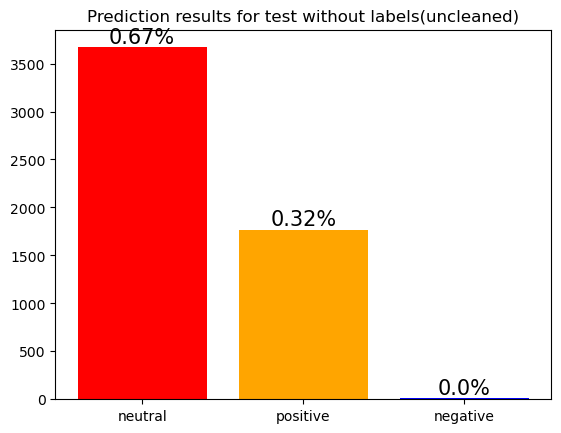

In [205]:
# 100% labelled
bar_plot(y_pred_val_uncleaned,'validation(uncleaned)')
# prediction
bar_plot(y_pred_test_uncleaned,'test without labels(uncleaned)')

Interestingly, both the validation and prediction trials run on the completely raw uncleaned tweets seem to classify none of them as negative.

##### k-NN with cleaned tweets:

Our final attempt at k-NN sentiment label classification is performed on tweets which have been cleaned of all usernames, punctuation, stopwords, and lemmatized. As before, we run the k-NN algorithm on our pre-labelled set to get an idea of its accuracy and optimal k number:

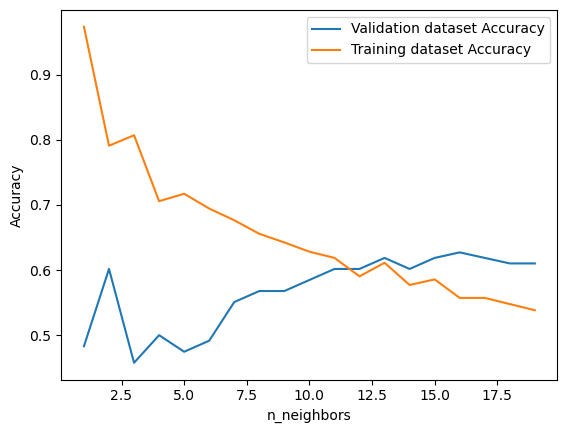

The optimal k is:  15
The confusion matrix for validation data is: 
 [[ 0  9  1]
 [ 0 67  2]
 [ 0 33  6]]
The accuracy of validation is:  0.6186440677966102


In [206]:
res_cleaned = merge_d(data_labelled_cleaned, data_test_cleaned)
y_pred_test_cleaned = res_cleaned[1]
y_pred_val_cleaned = res_cleaned[2]

Interestingly, 15 neighbors once again appears to be the optimal k, but this cleaned tweet k-NN model performs at a slighly lower accuracy than the uncleaned model at roughly 62%. Finally, we predict the sentiment labels for our unlabelled set of cleaned tweets and output their distributions below:

##### k-NN prediction of cleaned tweet sentiment labels:

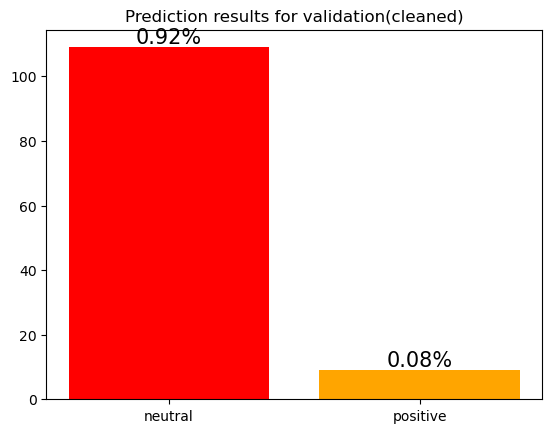

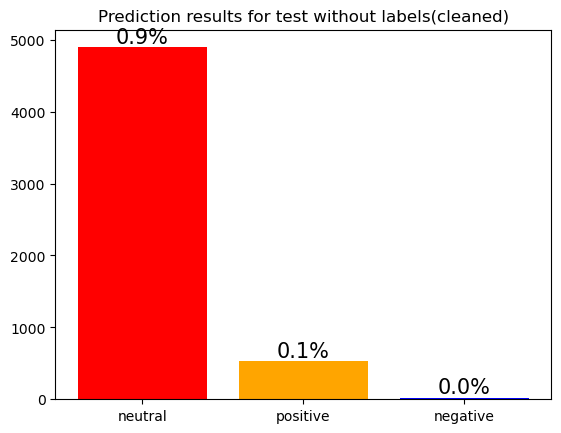

In [208]:
#100% labelled
bar_plot(y_pred_val_cleaned, 'validation(cleaned)')
#predicted
bar_plot(y_pred_test_cleaned, 'test without labels(cleaned)')

Once again, the validation and prediction k-NN trials run on the cleaned tweets do not seem to classify any of them as negative, and the cleaned version classifies the highest number of tweets as positive out of all the other trials.

Of the three k-NN models, we believe that the version which is run on the completely uncleaned set of tweets performs the best of all our k-NN models, due to its accuracy score. However, we do know from our manually labelled tweet data that some of our tweets are certainly of a negative sentiment, which has not been captured here. It's not a great accuracy score, but it does seem to be at least a little bit better than a coin toss!

### Third Model: VADER

For a third model, we looked towards a more established and popular method to analyze sentiment. We found this in the Natural Language ToolKit package’s VADER model, standing for Valence Aware Dictionary for sEntiment Reasoning. This model uses a pre-existing library of valence scores given to individual, context free words and combined with heuristics: outputs a determination for whether a string is positive, neutral, or negative. By using our cleaned tweets as a string, we input the data into the VADER package’s function polarity_scores() of the object SentimentIntensityAnalyzer() to obtain a dictionary of ratios. These tell us the approximated proportion of negative tweets, neutral tweets, and positive tweets along with the compounded score of all the ratios: 1. These values are then put into a boxplot for easier visualization of the ratios.


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...


True

In [ ]:
tokenized_words = word_tokenize(corpus_string, "english")
score = SentimentIntensityAnalyzer().polarity_scores(corpus_string)
score

{'neg': 0.103, 'neu': 0.691, 'pos': 0.206, 'compound': 1.0}

### Conclusion:

We set out to conduct a sentiment analysis on tweets about nuclear energy. We tried three different models to see which one worked best. Our first model, the use of LDA to separate our set of tweets into two distinct topics, did not produce groups with clearly identifiable sentiments. So, we moved on to trying a second model with k-NN and tried different versions of it. In our first version of k-NN, we drew upon our previous LDA model and used its topic probability outputs as 2-dimensional vectors as inputs. Unfortunately, this version of k-NN seemed to generate the lowest out of all our model attempts, with an estimated accuracy of 52%. However, this version was also the one that produced the most similar distributions to our true manually assigned distribution of sentiment labels! Very odd! 

For our next attempt, we input our completely uncleaned set of tweets into the algorithm with one-hot encoding. This version ended up generating the highest accuracy score of our k-NN models, estimated at 64%. 

Our final version of k-NN used tweets which have been lemmatized and cleaned of usernames, punctuation, non-English characters, and stop words, then one-hot encoded. This version generated a slightly worse accuracy score than the uncleaned version at roughly 62%. All in all, it’s hard to say which of our k-NN models is really doing better here. Our LDA vector k-NN has the worst accuracy score, but most closely matches the true sentiment distribution we manually assigned. Our uncleaned tweet k-NN does not match our manually labelled set as well, but seems to have a higher accuracy score.

For our final model, we drew on the Vader sentiment analysis package. This model was a good check against our other models as it is something we could easily import from the nltk package. Vader seemed to produce a distribution that was a bit in between our tweet-based k-NN models and our true manually assigned label distribution. It has the second most similar distribution to that set of data, next to the LDA-based k-NN model.

What we have learned is that sentiment analysis is a very difficult job. While we were manually labeling tweets for our training sets, we saw that the complexities of language can make true sentiment unclear. Many people on Twitter use sarcastic and negative language regardless of the sentiment they are expressing about nuclear energy, and while it seems our k-NN and Vader models may have been able to cut through some of that, the broad vocabulary of the English language and the fact that the same idea can be expressed with multiple different words might have still been the reason that our models did not seem to have very good accuracy. 
